In [ ]:

!pip install yfinance pandas numpy scikit-learn xgboost statsmodels matplotlib

[*********************100%***********************]  18 of 18 completed



--- FINAL SYSTEM ---
Final Value: 1122684
Sharpe: 1.22
Max DD: -6.05 %


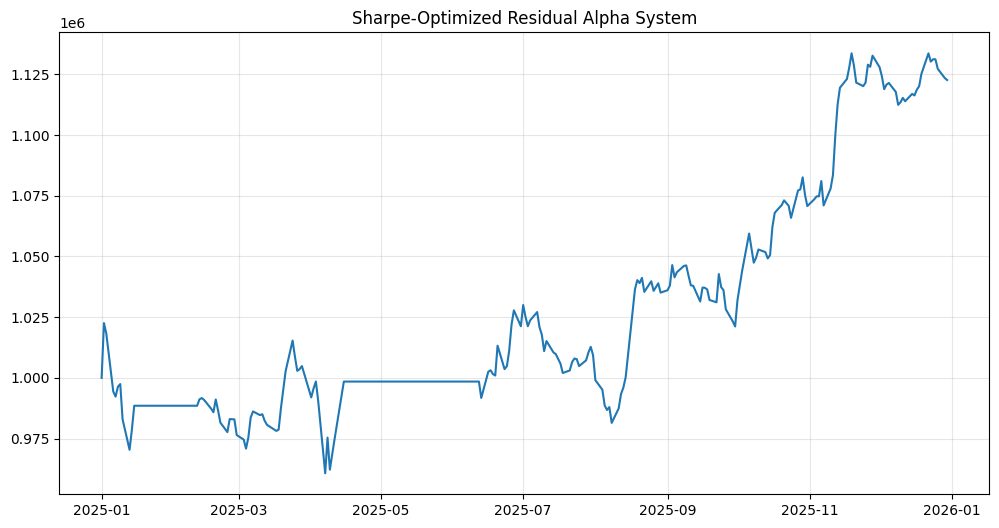

In [20]:
# ================== IMPORTS ==================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ================== CONFIG ==================
CAPITAL = 1_000_000
TRAIN_START, TRAIN_END = "2014-01-01", "2024-12-31"
TEST_START, TEST_END   = "2025-01-01", "2025-12-31"
LOOKAHEAD = 10
REBALANCE_FREQ = 10
LONGS = 5
SHORTS = 5

STOCKS = [
    "RELIANCE.NS","TCS.NS","INFY.NS","HDFCBANK.NS","ICICIBANK.NS","SBIN.NS",
    "KOTAKBANK.NS","AXISBANK.NS","LT.NS","ITC.NS","HINDUNILVR.NS",
    "BHARTIARTL.NS","ASIANPAINT.NS","HCLTECH.NS","MARUTI.NS","TITAN.NS","SUNPHARMA.NS"
]

# ================== DATA ==================
data = yf.download(STOCKS + ["^NSEI"], start="2013-01-01", end=TEST_END, auto_adjust=True)['Close'].ffill()
stocks = data[STOCKS]
nifty = data["^NSEI"]

stock_ret = stocks.pct_change()
nifty_ret = nifty.pct_change()
res_ret = stock_ret.sub(nifty_ret, axis=0)

# ================== SIGNALS ==================
meanrev = (stocks - stocks.rolling(20).mean()) / stocks.rolling(20).std()
res_mom = res_ret.rolling(20).mean()
stat_arb = res_ret - res_ret.rolling(60).mean()

def cs_z(df):
    return df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)

meanrev, res_mom, stat_arb = cs_z(meanrev), cs_z(res_mom), cs_z(stat_arb)

# ================== ALPHA ENGINE ==================
alpha = 0.35*meanrev + 0.35*res_mom + 0.30*stat_arb
alpha = cs_z(alpha).ewm(span=5).mean()

agree = ((meanrev>0).astype(int) + (res_mom>0).astype(int) + (stat_arb>0).astype(int))
alpha = alpha.where((agree>=2)|(agree<=-2),0)

mkt_vol = nifty_ret.rolling(20).std()
alpha = alpha.where(mkt_vol < mkt_vol.rolling(200).mean(), 0)

# Vol-normalize
alpha_vol = alpha.rolling(30).std()
alpha = (alpha / alpha_vol).clip(-3,3)

# Persistence filter
alpha = alpha.where(np.sign(alpha)==np.sign(alpha.rolling(3).mean()),0)

# ================== BACKTEST ==================
cash = CAPITAL
portfolio = {}
prev_portfolio = {}
equity_curve = []
dates = stocks.loc[TEST_START:TEST_END].index

for i, d in enumerate(dates):

    equity = cash + sum(p["qty"] * stocks.loc[d, s] for s,p in portfolio.items())
    equity_curve.append(equity)

    if i % REBALANCE_FREQ != 0:
        continue

    for s,p in portfolio.items():
        cash += p["qty"] * stocks.loc[d, s]
    prev_portfolio = portfolio.copy()
    portfolio.clear()

    scores = alpha.loc[d].dropna()
    if len(scores) < LONGS+SHORTS:
        continue

    longs, shorts = scores.nlargest(LONGS), scores.nsmallest(SHORTS)

    res_vol = res_ret.rolling(30).std().loc[d]
    strength = pd.concat([longs.abs(), shorts.abs()])
    strength = strength[~strength.index.duplicated()]

    weights = (strength/strength.sum()) / res_vol[strength.index]
    weights = weights/weights.sum()

    lev = (strength/strength.mean()).clip(0.5,2)

    beta = stock_ret.rolling(120).cov(nifty_ret)/nifty_ret.rolling(120).var()
    beta_today = beta.loc[d]

    long_beta = sum(beta_today.get(s,0)*weights.get(s,0) for s in longs.index)
    short_beta = sum(beta_today.get(s,0)*weights.get(s,0) for s in shorts.index)

    hedge_factor = 1/(1+abs(long_beta-short_beta)) if not(pd.isna(long_beta)|pd.isna(short_beta)) else 1

    for side, picks in [(1,longs.index),(-1,shorts.index)]:
        for s in picks:
            px = stocks.loc[d,s]
            if pd.isna(px) or px<=0: continue

            w, l = weights.get(s,np.nan), lev.get(s,np.nan)
            if pd.isna(w) or pd.isna(l): continue

            qty_val = (equity*0.5*hedge_factor*w*l)/px
            if pd.isna(qty_val) or qty_val<=0: continue

            qty = int(qty_val)
            portfolio[s]={"qty":side*qty}
            cash -= side*qty*px

# ================== PERFORMANCE ==================
res_equity = pd.Series(equity_curve,index=dates)
rets = res_equity.pct_change().dropna()
sharpe = np.sqrt(252)*rets.mean()/rets.std()
max_dd = (res_equity/res_equity.cummax()-1).min()

print("\n--- FINAL SYSTEM ---")
print("Final Value:",int(res_equity.iloc[-1]))
print("Sharpe:",round(sharpe,2))
print("Max DD:",round(max_dd*100,2),"%")

plt.figure(figsize=(12,6))
plt.plot(res_equity)
plt.title("Sharpe-Optimized Residual Alpha System")
plt.grid(alpha=0.3)
plt.show()
